In [1]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

In [2]:
data = sm.datasets.co2.load_pandas()

In [3]:
df = data.data

In [4]:
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [5]:
df = df['co2'].resample('MS').mean()

In [6]:
df.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

In [7]:
df.isnull().sum()

5

In [8]:
df = df.fillna(df.bfill())

In [9]:
df.isnull().sum()

0

In [10]:
train = df[:'1997-12-01']
test = df['1998-01-01':]

In [11]:
# ARIMA(p, d, q): (Autoregressive Integrated Moving Average)

In [12]:
arima_model = ARIMA(train, order=(1, 1, 1)).fit()

In [13]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    co2   No. Observations:                  478
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -575.768
Date:                Thu, 20 Jul 2023   AIC                           1157.537
Time:                        23:55:06   BIC                           1170.039
Sample:                    03-01-1958   HQIC                          1162.452
                         - 12-01-1997                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5669      0.054     10.586      0.000       0.462       0.672
ma.L1          0.3284      0.062      5.306      0.000       0.207       0.450
sigma2         0.6534      0.050     12.965      0.000       0.555       0.752
===================================================================================
Ljung-Box (L1) (Q):                   2.26   Jarque-Bera (JB):                 3.96
Prob(Q):                              0.13   Prob(JB):                         0.14
Heteroskedasticity (H):               0.98   Skew:                             0.09
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
y_pred = arima_model.forecast(48)

In [15]:
y_pred = y_pred.values
y_pred = pd.Series(y_pred, index=test.index)
y_pred

1998-01-01    365.558639
1998-02-01    366.300479
1998-03-01    366.721012
1998-04-01    366.959404
1998-05-01    367.094543
1998-06-01    367.171151
1998-07-01    367.214578
1998-08-01    367.239196
1998-09-01    367.253151
1998-10-01    367.261062
1998-11-01    367.265547
1998-12-01    367.268089
1999-01-01    367.269530
1999-02-01    367.270347
1999-03-01    367.270810
1999-04-01    367.271073
1999-05-01    367.271222
1999-06-01    367.271306
1999-07-01    367.271354
1999-08-01    367.271381
1999-09-01    367.271396
1999-10-01    367.271405
1999-11-01    367.271410
1999-12-01    367.271413
2000-01-01    367.271414
2000-02-01    367.271415
2000-03-01    367.271416
2000-04-01    367.271416
2000-05-01    367.271416
2000-06-01    367.271416
2000-07-01    367.271416
2000-08-01    367.271416
2000-09-01    367.271416
2000-10-01    367.271416
2000-11-01    367.271416
2000-12-01    367.271416
2001-01-01    367.271417
2001-02-01    367.271417
2001-03-01    367.271417
2001-04-01    367.271417


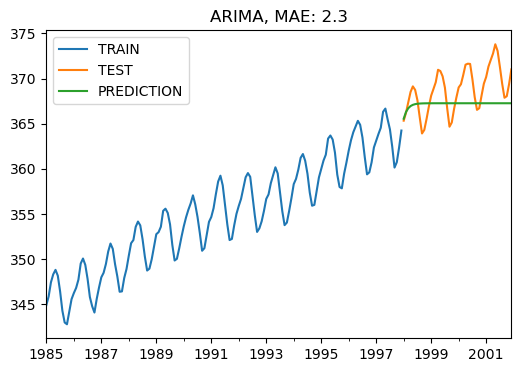

In [16]:
def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train["1985":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show(block=True)
    
plot_co2(train, test, y_pred, "ARIMA")

In [17]:
# Hyperparameter Optimization

In [18]:
# AIC & BIC

In [19]:
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

In [20]:
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order=order).fit()
            aic = arima_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params

In [21]:
best_params_aic = arima_optimizer_aic(train, pdq)

ARIMA(0, 0, 0) AIC=3954.01
ARIMA(0, 0, 1) AIC=3312.73
ARIMA(0, 0, 2) AIC=2771.31
ARIMA(0, 0, 3) AIC=2328.74
ARIMA(0, 1, 0) AIC=1523.91
ARIMA(0, 1, 1) AIC=1254.79
ARIMA(0, 1, 2) AIC=1137.97
ARIMA(0, 1, 3) AIC=1094.51
ARIMA(0, 2, 0) AIC=1279.81
ARIMA(0, 2, 1) AIC=1257.89
ARIMA(0, 2, 2) AIC=1247.74
ARIMA(0, 2, 3) AIC=1141.50
ARIMA(0, 3, 0) AIC=1482.91
ARIMA(0, 3, 1) AIC=1286.29
ARIMA(0, 3, 2) AIC=1264.05
ARIMA(0, 3, 3) AIC=1253.48
ARIMA(1, 0, 0) AIC=1536.61
ARIMA(1, 0, 1) AIC=1267.22
ARIMA(1, 0, 2) AIC=1149.98
ARIMA(1, 0, 3) AIC=1105.72
ARIMA(1, 1, 0) AIC=1207.78
ARIMA(1, 1, 1) AIC=1157.54
ARIMA(1, 1, 2) AIC=1113.98
ARIMA(1, 1, 3) AIC=1095.90
ARIMA(1, 2, 0) AIC=1256.05
ARIMA(1, 2, 1) AIC=1257.80
ARIMA(1, 2, 2) AIC=1161.11
ARIMA(1, 2, 3) AIC=1117.55
ARIMA(1, 3, 0) AIC=1418.84
ARIMA(1, 3, 1) AIC=1262.06
ARIMA(1, 3, 2) AIC=1263.84
ARIMA(1, 3, 3) AIC=1253.50
ARIMA(2, 0, 0) AIC=1217.86
ARIMA(2, 0, 1) AIC=1168.38
ARIMA(2, 0, 2) AIC=1124.96
ARIMA(2, 0, 3) AIC=1106.92
ARIMA(2, 1, 0) AIC=1103.53
A

In [22]:
best_params_aic

(2, 1, 3)

In [23]:
arima_model = sm.tsa.arima.ARIMA(train, order=best_params_aic).fit()

In [24]:
y_pred = arima_model.forecast(48)
y_pred = y_pred.values
y_pred = pd.Series(y_pred, index=test.index)

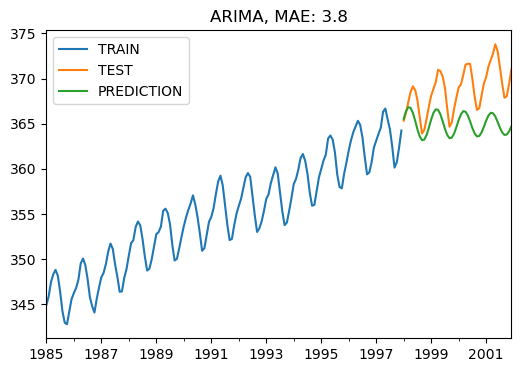

In [25]:
plot_co2(train, test, y_pred, "ARIMA")